In [1]:
# torch and visulization
from tqdm             import tqdm
import torch.optim    as optim
from torch.optim      import lr_scheduler
from torchvision      import transforms
from torch.utils.data import DataLoader
from model.parse_args_train import  parse_args

# metric, loss .etc
from model.utils import *
from model.metric import *
from model.loss import *
from model.load_param_data import  load_dataset, load_param

# model
from model.model_DNANet import  Res_CBAM_block
from model.model_DNANet import  DNANet

Text(0, 0.5, 'SIGMα')

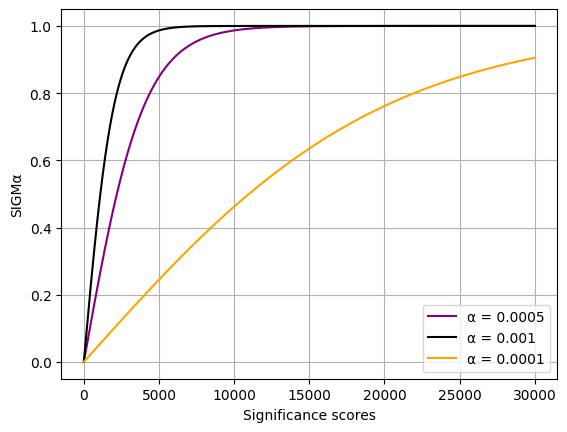

In [2]:
# SIGMAα activation function (Ntest=1)
from model.model_DeepNFA import SIGMalpha

sigma1 = SIGMalpha(0.0005)
sigma2 = SIGMalpha(0.001)
sigma3 = SIGMalpha(0.0001)

x = torch.arange(0,30001).unsqueeze(1).unsqueeze(1)

y1 = sigma1(x)
y2 = sigma2(x)
y3 = sigma3(x)

plt.plot(x.squeeze(), y1.squeeze(), c='purple', label='α = 0.0005')
plt.plot(x.squeeze(), y2.squeeze(), c='black', label='α = 0.001')
plt.plot(x.squeeze(), y3.squeeze(), c='orange', label='α = 0.0001')
plt.legend()
plt.grid()
plt.xlabel('Significance scores')
plt.ylabel('SIGMα')

Text(0, 0.5, 'NFA')

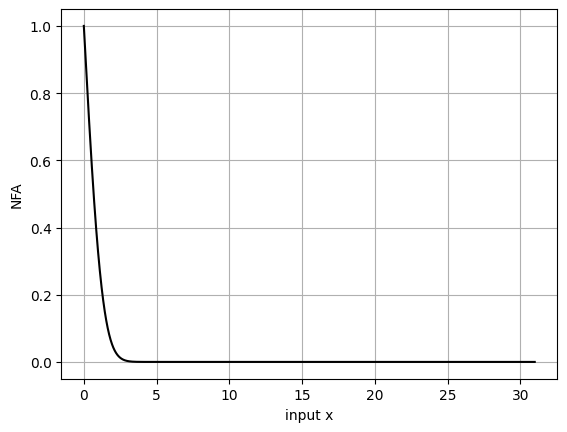

In [64]:
def gamma_approx(a, x):
    return torch.pow(x, a-1)*torch.exp(-x)*(1+(a-1)/x+(a-1)*(a-2)/torch.pow(x,2))

def NFA2(x, n_pixels, n_channels):
    return n_pixels*torch.special.gammaincc(n_channels/2,(torch.pow(x,2).sum(1))/2)

def NFA(x, n_pixels, n_channels):
    return (n_pixels/torch.exp(torch.special.gammaln(n_channels/2)))*gamma_approx(n_channels/2,(torch.pow(x,2).sum(1))/2)

x = torch.arange(0,31, step=0.01).unsqueeze(1).unsqueeze(1).unsqueeze(1)
n_pixels = torch.tensor(1)
n_channels = torch.tensor(1)
nfa = NFA2(x, n_pixels, n_channels)

plt.plot(x.squeeze(), nfa.squeeze(), c='black')
plt.grid()
plt.xlabel('input x')
plt.ylabel('NFA')

Text(0, 0.5, 'Significance')

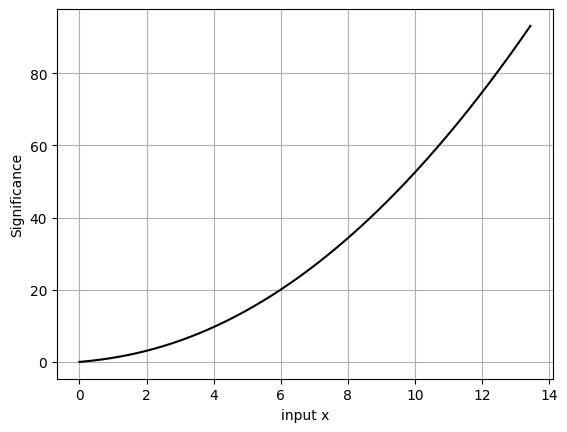

In [65]:
sign = -torch.log(nfa)
plt.plot(x.squeeze(), sign.squeeze(), c='black')
plt.grid()
plt.xlabel('input x')
plt.ylabel('Significance')

Text(0, 0.5, 'Significance score')

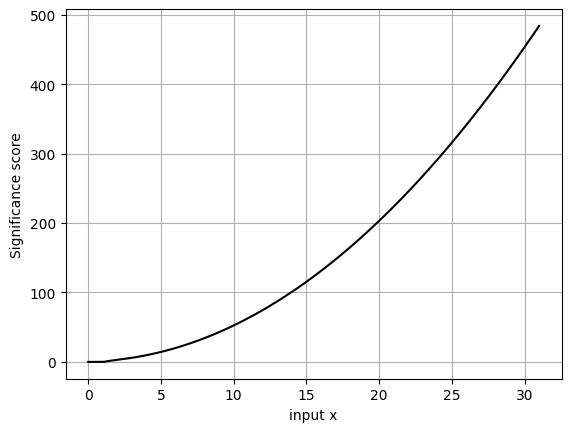

In [90]:
# Significance
from model.model_DeepNFA import Significance

signif = Significance()

x = torch.arange(0,31, step=0.01).unsqueeze(1).unsqueeze(1).unsqueeze(1)
y = signif(x)

plt.plot(x.squeeze(), y.squeeze(), c='black')
plt.grid()
plt.xlabel('input x')
plt.ylabel('Significance score')

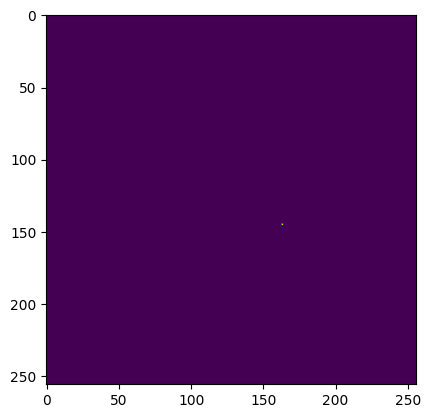

In [93]:
x = torch.randn((1, 8, 256, 256))

plt.imshow(signif(x)[0])

In [20]:
class ECABlock(nn.Module):
    def __init__(self, k_size=3):
        super(ECABlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        print(y.shape)
        print(y.squeeze(-1).transpose(-1, -2).shape)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        print(y.shape)
        y = self.sigmoid(y)
        print(y.expand_as(x).shape)
        return x * y.expand_as(x), y

In [22]:
eca_block = ECABlock()

x = torch.randn((32, 5, 256, 256))

x, y = eca_block(x)
y[0]

torch.Size([32, 5, 1, 1])
torch.Size([32, 1, 5])
torch.Size([32, 5, 1, 1])
torch.Size([32, 5, 256, 256])


tensor([[[0.5000]],

        [[0.4995]],

        [[0.4993]],

        [[0.5002]],

        [[0.5008]]], grad_fn=<SelectBackward0>)

In [2]:
from model.model_DeepNFA import DeepNFA

model = DeepNFA(3, Res_CBAM_block, [2, 2, 2, 2], [16, 32, 64, 128, 256], 0.0005).cuda()
model = model.apply(weights_init_xavier)

/media/cedric/Stockage1/Documents/Cours/MVA/Semestre2/Théorie de la détection et ses applications industrielles/report/Deep-NFA/model/utils.py:175: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


In [15]:
x = torch.randn((8, 3, 256, 256)).cuda()
significance, sign_scores_weigthed, sign_scores = model(x, visualization=True)

new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


In [16]:
significance = significance.detach().cpu().numpy()

In [17]:
np.isnan(significance).sum()

0

In [23]:
test_sign_scores = sign_scores[0][None,:,:,:]
test_sign_scores.shape

(1, 5, 256, 256)

In [24]:
test_sign_scores.max()

40.402664

In [31]:
test_sign_scores[0,2,128:132, 140:145] = 1000

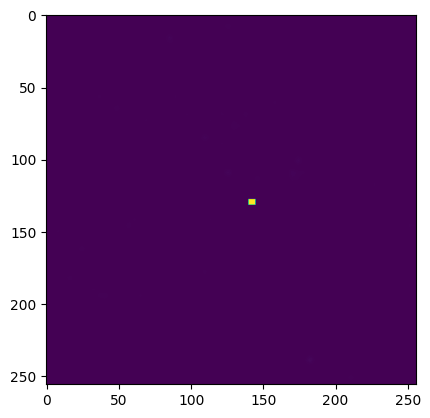

In [34]:
plt.imshow(test_sign_scores[0,2])

In [41]:
union_scores = test_sign_scores.max(axis=1)
union_scores.shape

(1, 256, 256)

In [42]:
union_scores.max()

1000.0

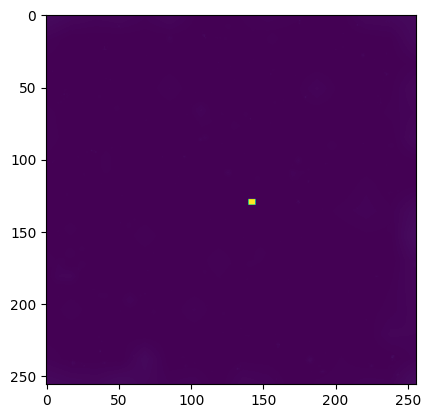

In [43]:
plt.imshow(union_scores[0])

In [19]:
significance.min()

0.0027725697

In [47]:
train_img_ids, val_img_ids, test_txt = load_dataset('dataset/', 'NUAA-SIRST', '60_40')
input_transform = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize([.485, .456, .406], [.229, .224, .225])])
testset         = TestSetLoader ('dataset/NUAA-SIRST',img_id=val_img_ids,base_size=256, crop_size=256, transform=input_transform,suffix='.png')
test_data  = DataLoader(dataset=testset,  batch_size=1, num_workers=4,drop_last=False)

In [50]:
model = DNANet(num_classes=1,input_channels=3, block=Res_CBAM_block, num_blocks=[2, 2, 2, 2], 
               nb_filter=[16, 32, 64, 128, 256], deep_supervision=True)
model           = model.cuda()
checkpoint             = torch.load('result/' + 'pretrained/pretrain_DNANet_model.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [51]:
model.eval()
with torch.no_grad():
    (data, labels) = next(iter(test_data))
    data = data.cuda()
    preds = model(data)
    pred =preds[-1]
pred = pred.detach().cpu().numpy()

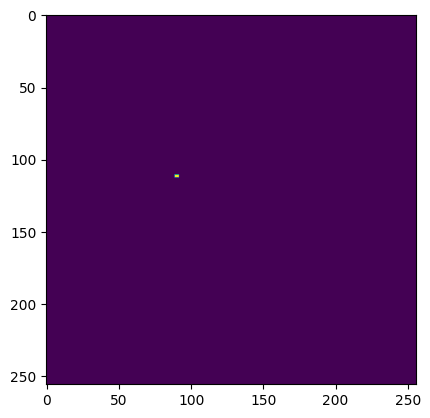

In [61]:
plt.imshow(labels[0,0])

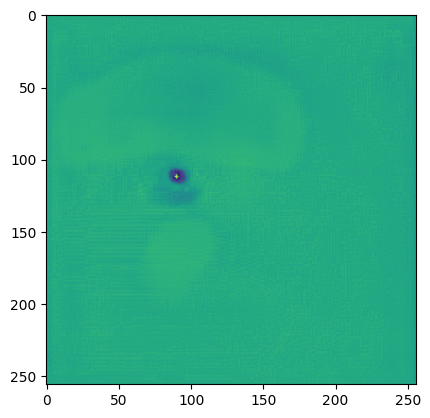

In [59]:
plt.imshow(pred[0,0])

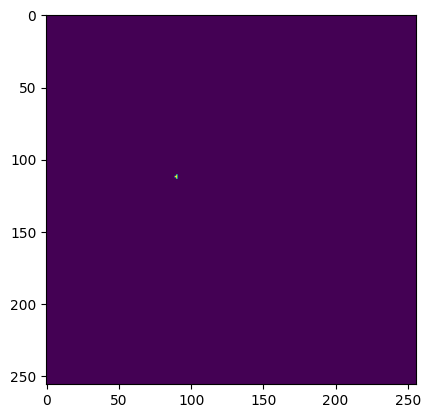

In [64]:
plt.imshow(np.array((pred > 0)[0,0]))

```bash
python train.py --base_size 256 --crop_size 256 --epochs 1000 --dataset NUAA-SIRST --split_method 60_40 --model DeepNFA --backbone resnet_18  --deep_supervision False --train_batch_size 8 --test_batch_size 8 --mode TXT --lr 0.03
```

```bash
python test.py --base_size 256 --crop_size 256 --st_model pretrained --model_dir pretrained/pretrain_DNANet_model.tar --dataset NUAA-SIRST --split_method 60_40 --model DNANet --backbone resnet_18  --deep_supervision True --test_batch_size 1 --mode TXT 
```
```bash
python visulization.py --base_size 256 --crop_size 256 --st_model NUAA-SIRST_DNANet_22_03_2024_01_46_45_wDS --model_dir NUAA-SIRST_DNANet_22_03_2024_01_46_45_wDS/mIoU__DNANet_NUAA-SIRST_epoch.pth.tar --dataset NUAA-SIRST --split_method 60_40 --model DNANet --backbone resnet_18  --deep_supervision True --test_batch_size 1 --mode TXT 
```


In [3]:
import scipy.io as scio

scio.loadmat('dataset/NUAA-SIRST/value_result/NUAA-SIRST_DNANet_22_03_2024_01_46_45_wDS_PD_FA_255.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar 22 16:31:42 2024',
 '__version__': '1.0',
 '__globals__': [],
 'number_record1': array([[1.48126256e-05, 5.97858987e-06, 5.97858987e-06, 5.35396107e-07,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'number_record2': array([[0.93518519, 0.84722222, 0.55092593, 0.23611111, 0.0462963 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]])}

In [4]:
scio.loadmat('dataset/NUAA-SIRST/value_result/pretrained_PD_FA_255')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar 22 17:38:48 2024',
 '__version__': '1.0',
 '__globals__': [],
 'number_record1': array([[2.24866365e-05, 1.27602739e-05, 2.32004980e-06, 8.03094161e-07,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'number_record2': array([[0.94907407, 0.89814815, 0.74074074, 0.43981481, 0.10185185,
         0.00925926, 0.00462963, 0.        , 0.        , 0.        ,
         0.        ]])}